In [222]:
import numpy as np
import matplotlib.pyplot as plt
import matplotlib.image as mpimg
import time
import pandas as pd
import random 
import copy
from sklearn.linear_model import LinearRegression
from statsmodels.api import OLS

In [2]:
#Black = 0, Red = 1, Green = 2, Blue = 3
dice = {0: [4, 4, 4, 4, 0, 0],
        1: [6, 6, 2, 2, 2, 2],
        2: [5, 5, 5, 1, 1, 1],
        3: [3, 3, 3, 3, 3, 3]}

ladders = {1:38, 4:14, 9:31, 21:42, 28:84, 36:44, 51:67, 71:91, 80:100}
chutes =  {16:6, 48:26, 49:11, 56:53, 62:19, 64:60, 87:24, 93:73, 95:75, 98:78}

In [83]:
def initialize(default = 0):
    # initialize Q  (101 states, 4 actions per state)
    Q = np.zeros((100, 4))      # state action values
    P = np.zeros((100)).astype(int)        # policy (default to 0=pass for each state)
    for p in range(len(P)):
        P[p] = default
    return Q,P
Q,P = initialize()

In [10]:
def makeTrajectory (P,epsilon):
    '''
    creates one trajectory and returns it
    P = current policy
    '''
    x = 0    # initial state
    traj = []  # trajectory
    

    while x != 100:
        #Picking die, then getting roll
        if epsilon >= random.random():
            action = P[x]
        else:
            action = random.choice([0,1,2,3])
        
        roll = random.choice(dice[action])
        
        #Append action
        traj.append((x,action))
        
        nextSpace = x + roll
        if nextSpace <= 100:
            if nextSpace in ladders:
                nextSpace = ladders[nextSpace]
            elif nextSpace in chutes:
                nextSpace = chutes[nextSpace]
            x = nextSpace

    return traj

def processTrajectory (traj,Q,gamma):
    '''
    Process one trajectory and accumulate results in Q
    gamma is the discount factor (learning rate)
    '''
    
    n = len(traj)
    R = n - 1  # amount of turns before reaching end
    for s,a in traj:
        Q[s,a] = gamma*R + (1-gamma)*Q[s,a]
        R -= 1
        
def PolicyEvaluation ( M, Q, Policy, epsilon, gamma):
    '''
    Repeat M trials of MC learning
    '''
    
    for i in range(M):
        traj = makeTrajectory(Policy,epsilon)
        processTrajectory(traj,Q,gamma)
        
def PolicyImprovement (Q,P):
    '''
    Improve the policy
    '''
    P = np.argmin(Q,axis=1)
    return P
    
def PolicyIteration(Q,P,M,D,epsilon,gamma):
    '''
    Q = numpy array of Q values
    P = numpy array of actions (policy)
    M = number of iterations of policy Evaluation between each step of Policy Improvement
    D = number of iterations of Policy Iteration
    '''
    
    for d in range(D):
        PolicyEvaluation(M,Q,P,epsilon,gamma)
        P=PolicyImprovement(Q,P)
        
    return P

In [297]:
def testRun(p, dice, reps):
    """
    Plays a game of chutes and ladders using the presented optimal dice choices.
    Returns the average number of terms needed to win
    Parameters:
        p: list of optimal dice choices for each state/tile
        dice: dictionary containing the sides of each dice
        reps: Number of times the game is played
    """
    total = 0
    for count in range(reps):
        turns = 0
        x = 0
        while x != 100:
            
            turns += 1
            if turns > 500:
                #We intentionally cause an error here as this function is
                #called within try except blocks. We stop at 500 simply based
                #on the fact that it becomes incredibly incredibly unlikely
                #that any game using even random die, much less a selection that
                #is partially optimized.
                print(cause_error)
            
            d = dice[p[x]]
            roll = random.choice(d)
            
            nextSpace = x + roll
            if nextSpace <= 100:
                if nextSpace in ladders:
                    nextSpace = ladders[nextSpace]
                elif nextSpace in chutes:
                    nextSpace = chutes[nextSpace]
                x = nextSpace
        total += turns
    return total / reps         

In [298]:
def defaultAvgs(ms, ds):
    """
    Measures the expected turn count for all combinations of a provided set of
    iteration counts, evaluation counts, as well as all four dice. Also counts
    the number of infinite loops encountered within each iteration.
    Parameters:
        ms: List of evaluation counts
        ds: list of iteration counts
        default: default dice to use
    """
    defs = [0,1,2,3]
    defAvgs = []
    for default in defs:
        dAvg = []
        for d in ds:
            mAvg = []
            for m in ms:
                avgTotal = 0
                dnfCount = 0
                for count in range(100):
                    Q,P = initialize(default = default)
                    p = PolicyIteration(Q,P,m,d,0.1,0.001)
                    try:
                        avg = testRun(p, dice, ladders, chutes, 500)
                        avgTotal += avg
                    except:
                        #Infinite loop encountered
                        dnfCount += 1
                mAvg.append((avgTotal / (50 - dnfCount), dnfCount * 2))
            dAvg.append(mAvg)
        defAvgs.append(dAvg)
    return defAvgs
#defAvgs = defaultAvgs([5,10,15,20,25,30,35,40],[5,10,15,20,25,30,35,40])

In [41]:
def getMeshPerfs(defAvgs, default):
    """
    Converts test results to 'mesh usable' formats for both expected turn count and 
    """
    turns = copy.deepcopy(defAvgs[default])
    dnfs = copy.deepcopy(defAvgs[default])
    for d in range(len(turns)):
        for m in range(len(turns[d])):
            turns[d][m] = turns[d][m][0]
            dnfs[d][m] = dnfs[d][m][1]
    return turns, dnfs

"""
turns0, dnfs0 = getMeshPerfs(defAvgs, 0)
turns1, dnfs1 = getMeshPerfs(defAvgs, 1)
turns2, dnfs2 = getMeshPerfs(defAvgs, 2)
turns3, dnfs3 = getMeshPerfs(defAvgs, 3)
turnsList = [turns0, turns1, turns2, turns3]
dnfsList = [dnfs0, dnfs1, dnfs2, dnfs3]
"""

# Turn and DNF rate for M & D values 5 - 40

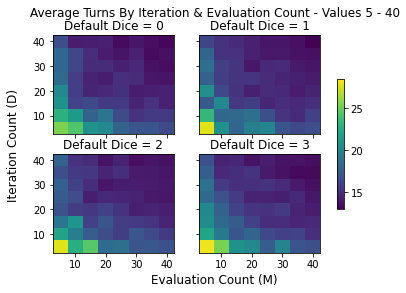

In [121]:
xy = [5,10,15,20,25,30,35,40]
fig, axs = plt.subplots(2, 2, sharey = True, sharex = True)
#fig.tight_layout()
for y in range(2):
    for x in range(2):
        diceNum = y*2 + x
        ax = axs[y, x]
        ax.set_title('Default Dice = ' + str(diceNum))
        pcm = ax.pcolormesh(xy,xy,turnsList[diceNum], vmin = 13, vmax = 28.5, shading = "auto")
fig.colorbar(pcm, ax=axs[:, :], shrink=0.6)
fig.supxlabel('Evaluation Count (M)')
fig.supylabel('Iteration Count (D)')
fig.suptitle('Average Turns By Iteration & Evaluation Count - Values 5 - 40')
plt.show()

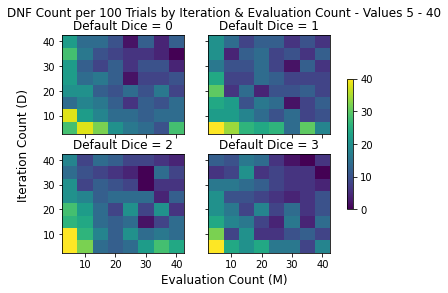

In [120]:
xy = [5,10,15,20,25,30,35,40]
fig, axs = plt.subplots(2, 2, sharey = True, sharex = True)
#fig.tight_layout()
fig.suptitle('DNF Count per 100 Trials by Iteration & Evaluation Count - Values 5 - 40')
for y in range(2):
    for x in range(2):
        diceNum = y*2 + x
        ax = axs[y, x]
        ax.set_title('Default Dice = ' + str(diceNum))
        pcm = ax.pcolormesh(xy,xy,dnfsList[diceNum], vmin = 0, vmax = 40, shading = "auto")
fig.colorbar(pcm, ax=axs[:, :], shrink=0.6)
fig.supxlabel('Evaluation Count (M)')
fig.supylabel('Iteration Count (D)')
plt.show()

# Testing Gamma Values

In [ ]:
def testGammas(gammas, mds):
    """
    Tests the influence of the gamma value over different shared evaluation and iteration
    counts. Also includes the DNF count for every 100 trials of the given combination.
    Parameters:
        gammas: list of gamma values to test
        mds: list of shared evaluation and iteration counts to use
    """
    gamPerfs = []
    for gamma in gammas:
        print("Gamma: " + str(gamma) + "\n")
        mdPerfs = []
        for md in mds:
            print("MD: " + str(md))
            avgTotal = 0
            dnfCount = 0
            for count in range(100):
                Q,P = initialize(default = 2)
                p = PolicyIteration(Q,P,md,md,0.1,gamma)
                try:
                    avg = testRun(p, dice, ladders, chutes, 500)
                    avgTotal += avg
                except:
                    dnfCount += 1
            mdPerfs.append((avgTotal / (100 - dnfCount), dnfCount))
        gamPerfs.append(mdPerfs)
    return gamPerfs
#gamPerfs = testGammas([0.1, 0.01, 0.001], [80,90,100,110,120,130,140,150,160,170,180,190,200,210,220,230])

In [60]:
"""
gamTurns01 = [gamPerfs[0][n][0] for n in range(8)]
gamDnfs01 =  [gamPerfs[0][n][1] for n in range(8)]
gamTurns001 = [gamPerfs[1][n][0] for n in range(8)]
gamDnfs001 =  [gamPerfs[1][n][1] for n in range(8)]
gamTurns0001 = [gamPerfs[2][n][0] for n in range(8)]
gamDnfs0001 =  [gamPerfs[2][n][1] for n in range(8)]
"""

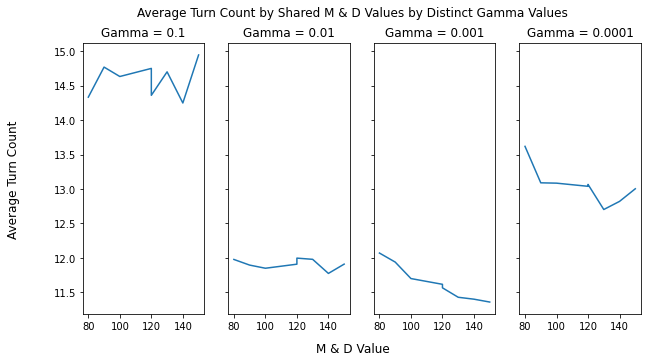

In [225]:
xy = [80,90,100,120,120,130,140,150]
fig, axs = plt.subplots(1,4, sharey = True, figsize=(10,5))
#fig.tight_layout()
axs[0].plot(xy, gamTurns01)
axs[0].set_title("Gamma = 0.1")
axs[1].plot(xy, gamTurns001)
axs[1].set_title("Gamma = 0.01")
axs[2].plot(xy, gamTurns0001)
axs[2].set_title("Gamma = 0.001")
axs[3].plot(xy, avgs00001)
axs[3].set_title("Gamma = 0.0001")
fig.supxlabel('M & D Value')
fig.supylabel('Average Turn Count')
fig.suptitle("Average Turn Count by Shared M & D Values by Distinct Gamma Values")
ax.set_ylim((10,15))
plt.show()

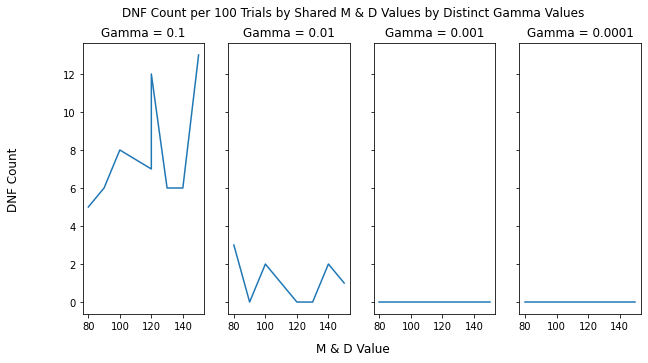

In [226]:
xy = [80,90,100,120,120,130,140,150]
fig, axs = plt.subplots(1,4, sharey = True, figsize=(10,5))
#fig.tight_layout()
axs[0].plot(xy, gamDnfs01)
axs[0].set_title("Gamma = 0.1")
axs[1].plot(xy, gamDnfs001)
axs[1].set_title("Gamma = 0.01")
axs[2].plot(xy, gamDnfs0001)
axs[2].set_title("Gamma = 0.001")
axs[3].plot(xy, gamDnfs0001)
axs[3].set_title("Gamma = 0.0001")
fig.supxlabel('M & D Value')
fig.supylabel('DNF Count')
fig.suptitle("DNF Count per 100 Trials by Shared M & D Values by Distinct Gamma Values")
ax.set_ylim((10,15))
plt.show()

Text(0.5, 0, 'M & D Value')

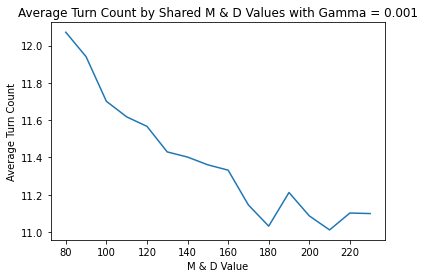

In [116]:
plt.plot([80,90,100,110,120,130,140,150,160,170,180,190,200,210,220,230], gamTurns0001)
plt.title("Average Turn Count by Shared M & D Values with Gamma = 0.001")
plt.ylabel("Average Turn Count")
plt.xlabel("M & D Value")

# Testing Epsilon Values

In [ ]:
def testEpsilons(mds, eps):
    """
    Tests the influence of the epsilon value over different shared evaluation and iteration
    counts. Also includes the DNF count for every 100 trials of the given combination.
    Parameters:
        eps: list of epsilon values to test
        mds: list of shared evaluation and iteration counts to use
    """
    epAvgs = []
    for ep in eps:
        print("EP: " + str(ep) + "\n")
        nAvgs = []
        for md in mds:
            print("MD: " + str(n))
            avgTotal = 0
            dnf = 0
            for count in range(100):
                Q,P = initialize()
                p = PolicyIteration(Q,P,md,md,ep,0.001)
                try:
                    avg = testRun(p, dice, ladders, chutes, 500)
                    avgTotal += avg
                except:
                    dnf += 1
            nAvgs.append((avgTotal / (50 - dnf), dnf))
        epAvgs.append(nAvgs)
    return epAvgs
#epAvgs = testEpsilons([20,25,30,35,40,45,50,55,60,65,70,75,80,85,90,95,100], [0.1,0.01,0.001])

In [144]:
"""
#Separating epsilon test results to separate lists for graphing purposes.
epTurns01 = [epAvgs[0][n][0] for n in range(len(epAvgs[0]))]
epDnfs01 =  [epAvgs[0][n][1] for n in range(len(epAvgs[0]))]
epTurns001 = [epAvgs[1][n][0] for n in range(len(epAvgs[0]))]
epDnfs001 =  [epAvgs[1][n][1] for n in range(len(epAvgs[0]))]
epTurns0001 = [epAvgs[2][n][0] for n in range(len(epAvgs[0]))]
epDnfs0001 =  [epAvgs[2][n][1] for n in range(15len(epAvgs[0]))]
"""

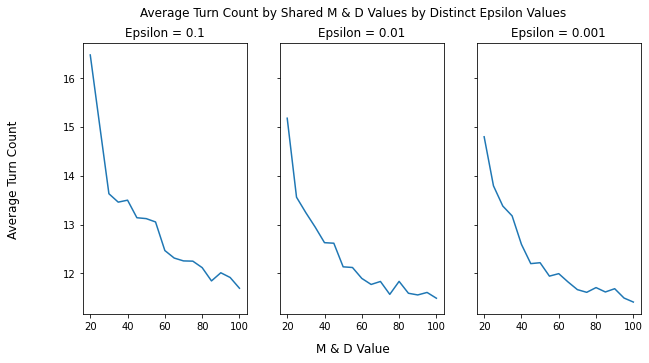

In [201]:
xy = [20,25,30,35,40,45,50,55,60,65,70,75,80,85,90,95,100]
fig, axs = plt.subplots(1,3, sharey = True, figsize=(10,5))
#fig.tight_layout()
axs[0].plot(xy, epTurns01)
axs[0].set_title("Epsilon = 0.1")
axs[1].plot(xy, epTurns001)
axs[1].set_title("Epsilon = 0.01")
axs[2].plot(xy, epTurns0001)
axs[2].set_title("Epsilon = 0.001")
fig.supxlabel('M & D Value')
fig.supylabel('Average Turn Count')
fig.suptitle("Average Turn Count by Shared M & D Values by Distinct Epsilon Values")
ax.set_ylim((10,20))
plt.show()

# Testing Optimal Simulation

In [302]:
#With Optimal gamma and epsilon values
def getAvgPerfs(md, reps):
    """
    Generates the average turn counts from 100 trials of the same Monte Carlo simulation over 5000 test runs each.
    Also returns a parallel LoL containing the p list.
    Parameters:
        md: Shared iteration and evaluation count
        reps: Number of trials
    """
    avgTotal = 0
    avgs = []
    ps = []
    for count in range(reps):
        Q,P = initialize()
        p = PolicyIteration(Q,P,md,md,0.001,0.001)
        avg = testRun(p, dice, 5000)
        avgs.append(avg)
        ps.append(p)
    return avgs, ps

In [ ]:
#avgs180, p180 = getAvgPerfs(180, 50)
#avgs90, p90 = getAvgPerfs(90, 50)

Text(0, 0.5, 'Bin Occurrence')

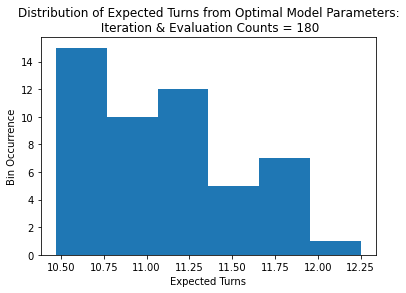

In [286]:
plt.hist(avgs180, bins = 6)
plt.title("Distribution of Expected Turns from Optimal Model Parameters:\n Iteration & Evaluation Counts = 180")
plt.xlabel("Expected Turns")
plt.ylabel("Bin Occurrence")

Text(0, 0.5, 'Bin Occurrence')

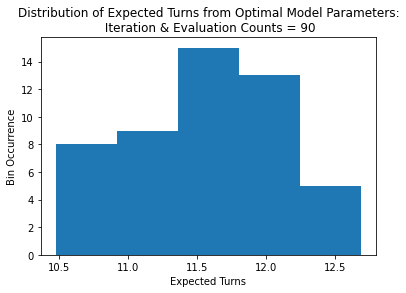

In [292]:
plt.hist(avgs90, bins = 5)
plt.title("Distribution of Expected Turns from Optimal Model Parameters:\n Iteration & Evaluation Counts = 90")
plt.xlabel("Expected Turns")
plt.ylabel("Bin Occurrence")

In [132]:
"""
diff180, diff180Count = avgPDiff(p180)
diff180Base = diff180Count[0]
diff180Count.append(0)
diff180Count = diff180Count[1:]
diff1802D = boardVision(diff180Count)
"""

In [131]:
def boardVision(board):
    newBoard = []
    for count in range(1, 11):
        left = (count - 1) % 2 != 0 
        if left:
            start = 9
            end = -10
            path = -1
        else:
            start = 0
            end = 10
            path = 1
        start += 10 * (count - 1)
        row = []
        for i in range(start, start + end, path):
            row.append(board[i])
        newBoard.append(row)
    return newBoard

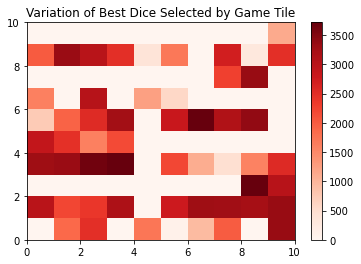

In [258]:
plt.pcolormesh(diff1802D, vmin = 0, vmax = 3716, shading = "auto", cmap=plt.cm.get_cmap('Reds'))
plt.title("Variation of Best Dice Selected by Game Tile")
plt.colorbar()

# Single Test of Optimal Parameters

In [306]:
getAvgPerfs(180, 1)

([10.6366],
 [array([2, 0, 1, 1, 0, 0, 3, 1, 2, 0, 2, 0, 2, 0, 3, 3, 0, 1, 3, 3, 3, 0,
         1, 2, 0, 3, 1, 2, 0, 2, 2, 2, 0, 3, 1, 2, 0, 0, 3, 3, 1, 2, 2, 0,
         3, 1, 2, 0, 0, 0, 2, 0, 1, 0, 2, 2, 0, 0, 2, 0, 3, 1, 0, 3, 0, 1,
         2, 0, 3, 1, 2, 0, 0, 3, 1, 2, 0, 3, 1, 2, 0, 2, 0, 1, 1, 3, 1, 0,
         1, 2, 0, 3, 0, 0, 1, 0, 0, 3, 0, 2], dtype=int64)])